Thanks so much to the [FollowYourEmoji](https://github.com/mayuelala/FollowYourEmoji) team for posting the code.

The original code is unstructured and lacks various pieces, so it took me, [daswer123](https://github.com/daswer123), some time to adapt the code to the free version of google collab.

If you liked my work, give the [repo](https://github.com/daswer123/FollowYourEmoji-colab) a star

# Install

In [ ]:
!git clone https://github.com/daswer123/FollowYourEmoji-colab FollowYourEmoji
%cd /content/FollowYourEmoji
!pip install -r requirements.txt

In [ ]:
# Get pretrained and base models
%cd /content/FollowYourEmoji
!git clone https://huggingface.co/YueMafighting/FollowYourEmoji /content/FollowYourEmoji/ckpt_models
!git clone https://huggingface.co/daswer123/FollowYourEmoji_BaseModelPack /content/FollowYourEmoji/ckpt_models/base

In [ ]:
# Upload examples
%cd /content/FollowYourEmoji
!mkdir examples
!wget https://github.com/KwaiVGI/LivePortrait/raw/main/assets/examples/driving/d10.mp4 -O /content/FollowYourEmoji/examples/video.mp4
!wget https://raw.githubusercontent.com/KwaiVGI/LivePortrait/main/assets/examples/source/s1.jpg -O /content/FollowYourEmoji/examples/img.jpg

In [ ]:
# Need for proper work
!pip install omegaconf
!pip install torch==2.1.1 torchvision==0.16.1 torchaudio==2.1.1
!pip install xformers==0.0.23
!pip install protobuf==4.25.3 mediapipe==0.10.13

# Restart envoriment to work correctly


In [ ]:
import os
import sys

# Перезагрузка среды
os.kill(os.getpid(), 9)

# Funcs init ( Launch every time when you restart session )

In [ ]:
%cd /content/FollowYourEmoji
ROOT = '/content/FollowYourEmoji'

import os
import cv2
import csv
import json
import math
import random
import decord
import numpy as np
import imageio
import matplotlib
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image, ImageSequence
from io import BytesIO
from IPython.display import Video,Image
from IPython.display import display, Image as IPyImage
# import torchvision.transforms as T

import sys
from media_pipe.mp_utils  import LMKExtractor
from media_pipe.draw_util import FaceMeshVisualizer
from media_pipe.pose_util import project_points_with_trans, matrix_to_euler_and_translation, euler_and_translation_to_matrix

def show_img(img, title=''):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(img)
    plt.show()

def read_video(video_path):
    vr = decord.VideoReader(video_path)
    frames = vr.get_batch(list(range(len(vr))))
    return frames

def display_gif(image_array, duration=100):
    # 将NumPy数组转换为PIL图像列表
    images = [Image.fromarray(frame) for frame in image_array]

    # 将图像保存为GIF并将其读入内存缓冲区
    buffer = BytesIO()
    images[0].save(buffer, format='GIF', save_all=True, append_images=images[1:], duration=duration, loop=0)

    # 在Jupyter Notebook中显示GIF
    buffer.seek(0)
    display(IPyImage(data=buffer.getvalue()))

lmk_extractor = LMKExtractor()
vis = FaceMeshVisualizer(forehead_edge=False)

/content/FollowYourEmoji


# Create Video NPY

In [ ]:
from tqdm import tqdm

video_path = f'/content/FollowYourEmoji/examples/video.mp4'
frames = imageio.get_reader(video_path)
face_results = []
motions = []
for frame in tqdm(frames):
    frame_bgr = cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR)

    face_result = lmk_extractor(frame_bgr)
    assert face_result is not None, "Can not detect a face in the reference image."
    face_result['width'] = frame_bgr.shape[1]
    face_result['height'] = frame_bgr.shape[0]

    face_results.append(face_result)
    lmks = face_result['lmks'].astype(np.float32)
    motion = vis.draw_landmarks((frame_bgr.shape[1], frame_bgr.shape[0]), lmks, normed=True)
    motions.append(motion)

print(len(motions))

save_path_gif = video_path.replace('.mp4', '_mppose.gif')
imageio.mimsave(save_path_gif, motions, 'GIF', duration=0.2, loop=0)
print(save_path_gif, 'done')

save_path = video_path.replace('.mp4', '_mppose.npy')
np.save(save_path, face_results)
print(save_path, 'done')

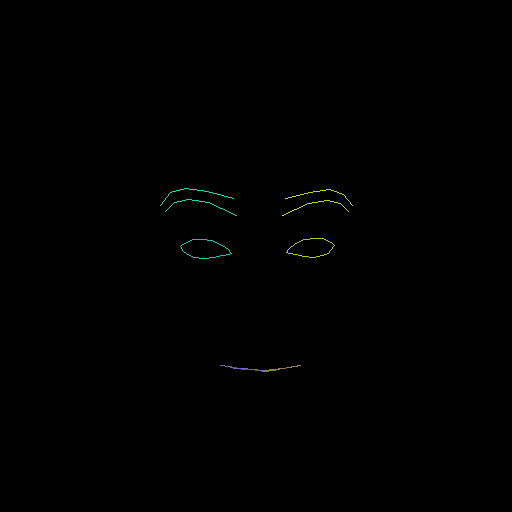

In [ ]:
display_gif(motions)

# Launch

1. You need to specify path to your img ( you need upload it before )
2. You need to create video NPY and specify path in lkm_path
3. In configs/infer.yaml you need to specify your video fps
4. Your result will be in data/out folder

In [ ]:
# Free version of colab requer to restart session every launch
# Clear memory
import os
import gc
import torch

gc.collect()
torch.cuda.empty_cache()
os.kill(os.getpid(), 9)

In [ ]:
%cd /content/FollowYourEmoji

import os
os.environ['LOCAL_IP'] = '127.0.0.1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

!python3 -m torch.distributed.run \
    --nnodes 1 \
    --master_addr $LOCAL_IP \
    --master_port 8888 \
    --node_rank 0 \
    --nproc_per_node 1 \
    infer.py \
    --config ./configs/infer.yaml \
    --model_path ./ckpt_models/ckpts \
    --input_path  /content/FollowYourEmoji/examples/img.jpg \
    --lmk_path  /content/FollowYourEmoji/examples/video_mppose.npy \
    --output_path ./data/out \
    --model_step 10

In [ ]:
%cd /content/FollowYourEmoji

# Show your video
from base64 import b64encode
from IPython.display import HTML

video_path = "/content/FollowYourEmoji/data/out/video_mppose_img_all.mp4"

def show_video(video_path):
    video_file = open(video_path, "rb").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""
    <video width=1000 controls>
        <source src="{video_url}" type="video/mp4">
    </video>
    """)


show_video(video_path)


/content/FollowYourEmoji


# Create IMG NPY

In [ ]:
# 测试能否被检测到landmark


# Specify path to your img

ref_image_path = '/content/FollowYourEmoji/examples/img.jpg'
ref_image_pil = Image.open(ref_image_path).convert("RGB")
ref_image_np = cv2.cvtColor(np.array(ref_image_pil), cv2.COLOR_RGB2BGR)
# show_img(ref_image_pil)

face_result = lmk_extractor(ref_image_np)
assert face_result is not None, "Can not detect a face in the reference image."
face_result['width'] = ref_image_np.shape[1]
face_result['height'] = ref_image_np.shape[0]

save_path = ref_image_path.replace('.png', '_mppose.npy')
np.save(save_path, face_result)

lmks = face_result['lmks'].astype(np.float32)
ref_pose = vis.draw_landmarks((ref_image_np.shape[1], ref_image_np.shape[0]), lmks, normed=True)
show_img(ref_pose)

AttributeError: type object 'Image' has no attribute 'open'